In [3]:
import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

In [4]:
import sys, torch
print(sys.executable)
print("CUDA:", torch.cuda.is_available(), "CUDA ver:", torch.version.cuda, "Torch:", torch.__version__)


c:\Users\micha\Downloads\Primarymodel\.venv\Scripts\python.exe
CUDA: True CUDA ver: 12.1 Torch: 2.5.1+cu121


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
        """ Generate a name for the model consisting of all the hyperparameter values

        Args:
            config: Configuration object containing the hyperparameters
        Returns:
            path: A string with the hyperparameter name and value concatenated
        """
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
        return path

In [6]:
#Ensuring CUDA is being used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision("high")  
use_amp = (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Using device: cuda


C:\Users\micha\AppData\Local\Temp\ipykernel_57480\1532802620.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [7]:
IMSIZE = 260
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMSIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.02),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMSIZE*1.1)),
    transforms.CenterCrop(IMSIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [13]:

num_countries = 5

model = timm.create_model(
    'efficientnet_b5',
    pretrained=True,
    num_classes=num_countries,   # 5 countries
    drop_rate=0.3,               # no more overfit
    drop_path_rate=0.2           # stochastic depth
)

# sanity check
print("out_features:", model.get_classifier().out_features) 

if device.type == "cuda":
    model = model.to(device, memory_format=torch.channels_last)
else:
    model = model.to(device)


out_features: 5


In [11]:
import math, gc, time
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
from timm.utils import ModelEmaV2
from tqdm import tqdm

def train_val(
    model,
    lr,
    batch_size,
    num_epochs,
    return_history: bool = False,
    use_ema: bool = True,
    use_tta: bool = False,
    use_amp: bool = True,
    num_workers: int = 8,
):
    """Assumes `train_tfms`, `val_tfms`, and `num_countries` exist."""
    # --- Data ---
    train_dataset = ImageFolder(root='data/train', transform=train_tfms)
    val_dataset   = ImageFolder(root='data/val',   transform=val_tfms)

    # Ensure identical class order for train/val
    name_to_idx = {name: i for i, name in enumerate(train_dataset.classes)}
    assert set(train_dataset.classes) == set(val_dataset.classes), \
        f"Class mismatch!\nTrain-only: {set(train_dataset.classes)-set(val_dataset.classes)}\nVal-only: {set(val_dataset.classes)-set(train_dataset.classes)}"
    val_dataset.samples = [(p, name_to_idx[val_dataset.classes[y]]) for (p, y) in val_dataset.samples]
    val_dataset.targets = [t for _, t in val_dataset.samples]
    val_dataset.classes = train_dataset.classes
    val_dataset.class_to_idx = name_to_idx

    is_cuda = torch.cuda.is_available()
    pin = is_cuda
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=(num_workers > 0), prefetch_factor=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=(num_workers > 0), prefetch_factor=2
    )

    # --- Losses ---
    soft_criterion = SoftTargetCrossEntropy()
    hard_criterion = nn.CrossEntropyLoss()

    # Milder mixup; skip epoch 0 to avoid depressed early accuracy
    def mixup_for_epoch(e):
        if e < 1:
            return None
        elif e < 0.60 * num_epochs:
            return Mixup(0.1, 0.8, prob=0.7, num_classes=num_countries)
        elif e < 0.85 * num_epochs:
            return Mixup(0.1, 0.4, prob=0.5, num_classes=num_countries)
        else:
            return None

    # --- Optimizer & Scheduler ---
    # Lighter weight decay to help early fitting
    optimizer = torch.optim.AdamW(
        (p for p in model.parameters() if p.requires_grad),
        lr=lr, weight_decay=1e-4
    )
    steps_per_epoch = max(len(train_loader), 1)
    warmup_epochs = 1  # shorter warmup for faster early progress
    warmup_steps  = warmup_epochs * steps_per_epoch
    total_steps   = num_epochs * steps_per_epoch

    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        t = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1.0 + math.cos(math.pi * t))  # cosine

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # --- AMP / EMA ---
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp and is_cuda)
    ema = ModelEmaV2(model, decay=0.999) if (use_ema and is_cuda) else None

    # Move model to the right device and set channels_last once
    device = next(model.parameters()).device
    if is_cuda and device.type != "cuda":
        device = torch.device("cuda")
        model.to(device)
    if device.type == "cuda":
        model.to(memory_format=torch.channels_last)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, seen, train_correct = 0.0, 0, 0
        t0 = time.time()
        mixup_fn = mixup_for_epoch(epoch)

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            hard_labels = labels.to(device, non_blocking=True)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            if device.type == "cuda":
                images = images.to(memory_format=torch.channels_last)

            if mixup_fn is not None:
                images, labels = mixup_fn(images, labels)     # labels are soft
                target_for_loss = labels
                criterion = soft_criterion
                metric_targets = labels.argmax(dim=1)         # hard target for accuracy metric
            else:
                target_for_loss = hard_labels
                criterion = hard_criterion
                metric_targets = hard_labels

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp and is_cuda):
                outputs = model(images)
                loss = criterion(outputs, target_for_loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if ema: ema.update(model)
            scheduler.step()

            bs = images.size(0)
            running_loss += loss.item() * bs
            seen += bs
            train_correct += (outputs.detach().argmax(1) == metric_targets).sum().item()

            del images, labels, outputs, loss, hard_labels, metric_targets

        train_loss = running_loss / max(seen, 1)
        train_acc_pct = 100.0 * train_correct / max(seen, 1)

        # --- Validation ---
        eval_model = ema.module if ema is not None else model
        eval_model.eval()
        vloss, vcorrect, vtotal = 0.0, 0, 0
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp and is_cuda):
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                if device.type == "cuda":
                    images = images.to(memory_format=torch.channels_last)
                out = eval_model(images)
                if use_tta:
                    out = (out + eval_model(torch.flip(images, dims=[3]))) / 2
                vloss += F.cross_entropy(out, labels).item() * images.size(0)
                vcorrect += (out.argmax(1) == labels).sum().item()
                vtotal += labels.size(0)
                del images, labels, out

        val_loss = vloss / max(vtotal, 1)
        val_acc  = vcorrect / max(vtotal, 1)
        val_acc_pct = 100.0 * val_acc

        dt = time.time() - t0
        print(f"Epoch {epoch+1}/{num_epochs}: {dt:.1f}s | "
              f"train {train_loss:.4f} | train_acc {train_acc_pct:.1f}% | "
              f"val {val_loss:.4f} | val_acc {val_acc_pct:.1f}% | "
              f"lr {scheduler.get_last_lr()[0]:.2e}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc_pct)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc_pct)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save((ema.module if ema is not None else model).state_dict(), "best_b5.pt")
            print("  ↳ saved new best")

        gc.collect()
        if is_cuda:
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

    return (best_acc, history) if return_history else best_acc


C:\Users\micha\AppData\Local\Temp\ipykernel_57480\962607772.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp and is_cuda)
Epoch 1/20:   0%|          | 0/138 [00:00<?, ?it/s]C:\Users\micha\AppData\Local\Temp\ipykernel_57480\962607772.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and is_cuda):
C:\Users\micha\AppData\Local\Temp\ipykernel_57480\962607772.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp and is_cuda):


Epoch 1/20: 170.4s | train 3.0354 | train_acc 38.5% | val 4.7772 | val_acc 23.2% | lr 3.00e-04
  ↳ saved new best


Epoch 2/20: 71.7s | train 1.5054 | train_acc 53.5% | val 3.3029 | val_acc 30.4% | lr 2.98e-04
  ↳ saved new best


Epoch 3/20: 71.4s | train 1.2428 | train_acc 62.5% | val 2.3554 | val_acc 34.0% | lr 2.92e-04
  ↳ saved new best


Epoch 4/20: 70.8s | train 1.1631 | train_acc 68.0% | val 1.7690 | val_acc 44.3% | lr 2.82e-04
  ↳ saved new best


Epoch 5/20: 71.1s | train 1.0004 | train_acc 75.0% | val 1.3321 | val_acc 55.1% | lr 2.68e-04
  ↳ saved new best


Epoch 6/20: 71.2s | train 0.9987 | train_acc 75.5% | val 1.0637 | val_acc 61.3% | lr 2.52e-04
  ↳ saved new best


Epoch 7/20: 70.9s | train 0.9113 | train_acc 80.5% | val 0.9198 | val_acc 66.6% | lr 2.32e-04
  ↳ saved new best


Epoch 8/20: 70.8s | train 0.8708 | train_acc 84.6% | val 0.8323 | val_acc 68.9% | lr 2.10e-04
  ↳ saved new best


Epoch 9/20: 70.7s | train 0.8293 | train_acc 85.9% | val 0.7767 | val_acc 70.6% | lr 1.87e-04
  ↳ saved new best


Epoch 10/20: 70.6s | train 0.8112 | train_acc 85.9% | val 0.7379 | val_acc 72.8% | lr 1.62e-04
  ↳ saved new best


Epoch 11/20: 70.5s | train 0.7736 | train_acc 88.5% | val 0.7128 | val_acc 73.6% | lr 1.38e-04
  ↳ saved new best


Epoch 12/20: 70.9s | train 0.7728 | train_acc 90.1% | val 0.6942 | val_acc 74.3% | lr 1.13e-04
  ↳ saved new best


Epoch 13/20: 71.5s | train 0.6621 | train_acc 93.5% | val 0.6810 | val_acc 75.3% | lr 8.97e-05
  ↳ saved new best


Epoch 14/20: 71.5s | train 0.6577 | train_acc 93.0% | val 0.6715 | val_acc 75.5% | lr 6.80e-05
  ↳ saved new best


Epoch 15/20: 71.3s | train 0.6281 | train_acc 95.1% | val 0.6645 | val_acc 76.2% | lr 4.84e-05
  ↳ saved new best


Epoch 16/20: 70.0s | train 0.6036 | train_acc 96.5% | val 0.6613 | val_acc 76.2% | lr 3.16e-05


Epoch 17/20: 71.4s | train 0.5883 | train_acc 95.9% | val 0.6606 | val_acc 77.2% | lr 1.81e-05
  ↳ saved new best


Epoch 18/20: 70.2s | train 0.0575 | train_acc 99.6% | val 0.6616 | val_acc 77.4% | lr 8.13e-06
  ↳ saved new best


Epoch 19/20: 70.3s | train 0.0281 | train_acc 99.6% | val 0.6671 | val_acc 77.2% | lr 2.05e-06


Epoch 20/20: 70.1s | train 0.0205 | train_acc 99.9% | val 0.6757 | val_acc 77.4% | lr 0.00e+00


C:\Users\micha\AppData\Local\Temp\ipykernel_57480\52492352.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_b5.pt", map_location=de

Phase 1 best val acc: 77.45%


Epoch 1/5: 89.3s | train 0.0995 | train_acc 97.5% | val 0.6668 | val_acc 77.0% | lr 1.00e-04
  ↳ saved new best


Epoch 2/5: 70.4s | train 0.8961 | train_acc 81.7% | val 0.6675 | val_acc 77.2% | lr 8.54e-05
  ↳ saved new best


Epoch 3/5: 70.1s | train 0.7806 | train_acc 88.1% | val 0.6649 | val_acc 77.0% | lr 5.00e-05


Epoch 4/5: 69.9s | train 0.6567 | train_acc 92.9% | val 0.6652 | val_acc 76.6% | lr 1.46e-05


Epoch 5/5: 70.9s | train 0.6476 | train_acc 94.0% | val 0.6665 | val_acc 76.4% | lr 0.00e+00
Phase 2 best val acc: 77.23%


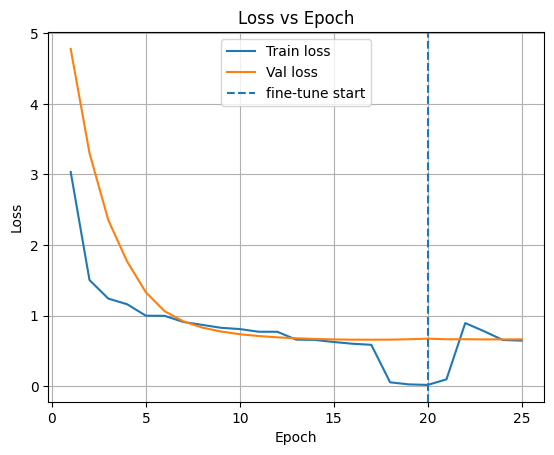

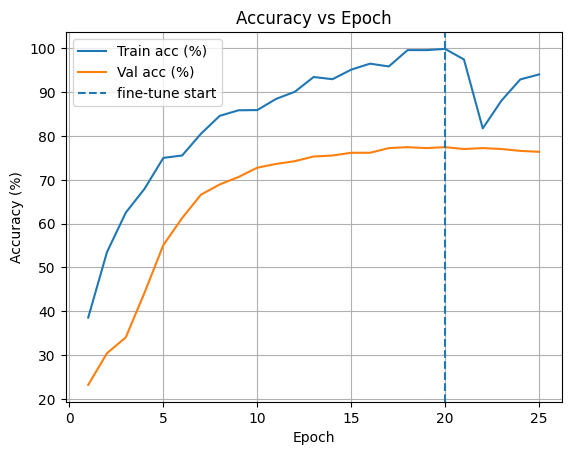

In [ ]:
lr1, bs, epochs1 = 3e-4, 16, 20
best1, hist1 = train_val(model, lr=lr1, batch_size=bs, num_epochs=epochs1, return_history=True)
print(f"Phase 1 best val acc: {best1*100:.2f}%")

# -------- Phase 2: fine-tune from best checkpoint (lower LR) --------
model.load_state_dict(torch.load("best_b5.pt", map_location=device))
best2, hist2 = train_val(model, lr=1e-4, batch_size=bs, num_epochs=5, return_history=True)
print(f"Phase 2 best val acc: {best2*100:.2f}%")

# Merge histories for plotting
hist = {k: hist1[k] + hist2[k] for k in hist1}
cut = len(hist1['train_loss'])

import matplotlib.pyplot as plt

epochs = range(1, len(hist['train_loss']) + 1)

# Loss
plt.figure()
plt.plot(epochs, hist['train_loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'],   label='Val loss')
plt.axvline(cut, linestyle='--', label='fine-tune start')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch')
plt.legend(); plt.grid(True)
plt.show()

# Accuracy (percent)
plt.figure()
plt.plot(epochs, hist['train_acc'], label='Train acc (%)')
plt.plot(epochs, hist['val_acc'],   label='Val acc (%)')
plt.axvline(cut, linestyle='--', label='fine-tune start')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy vs Epoch')
plt.legend(); plt.grid(True)
plt.show()


In [15]:
# Test dataset

test_dataset = ImageFolder(root='data/test', transform=val_tfms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [17]:
#Testing Accuracy

model.load_state_dict(torch.load("best_b5.pt", map_location=device))
model.eval()

test_loss = 0.0; correct = 0; total = 0
all_preds, all_labels = [], []

with torch.no_grad(), torch.amp.autocast('cuda', enabled=use_amp):
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        if device.type == "cuda":
            images = images.to(memory_format=torch.channels_last)

        outputs = model(images)
        test_loss += F.cross_entropy(outputs, labels).item() * images.size(0)

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

import torch
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

avg_loss = test_loss / max(total, 1)
acc = 100.0 * correct / max(total, 1)
print("Results from Unseen Data: ")
print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

C:\Users\micha\AppData\Local\Temp\ipykernel_57480\2876720458.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_b5.pt", map_location=

Results from Unseen Data: 
Test Loss: 0.6579 | Test Accuracy: 76.63%


In [ ]:
# PREDICTION FUNCTION
import os, json, torch, timm
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = (device.type == "cuda") if "use_amp" not in globals() else use_amp

# Use existing test transforms
if "val_tfms" in globals():
    infer_tfms = val_tfms
else:
    IMSIZE = globals().get("IMSIZE", 260)
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    infer_tfms = transforms.Compose([
        transforms.Resize(int(IMSIZE*1.1)),
        transforms.CenterCrop(IMSIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# Set class names
CLASSES_PATH = "class_names.json"
if os.path.exists(CLASSES_PATH):
    class_names = json.load(open(CLASSES_PATH, "r"))
else:
    _tmp = ImageFolder("data/train", transform=infer_tfms)
    class_names = _tmp.classes
    json.dump(class_names, open(CLASSES_PATH, "w"))
num_classes = len(class_names) if "num_countries" not in globals() else num_countries

# Load model data
if "infer_model" not in globals():
    infer_model = timm.create_model(
        "efficientnet_b5",
        pretrained=False,
        num_classes=num_classes,
        drop_rate=0.3,
        drop_path_rate=0.2,
    )
    state = torch.load("best_b5.pt", map_location=device)
    infer_model.load_state_dict(state, strict=True)
    infer_model = infer_model.to(device, memory_format=torch.channels_last) if device.type=="cuda" else infer_model.to(device)
    infer_model.eval()

@torch.no_grad()
def predict_image(path: str, topk: int = 5, tta: bool = True):
    img = Image.open(path).convert("RGB")       #prepare image for model passthrough
    x = infer_tfms(img).unsqueeze(0).to(device, non_blocking=True)
    if device.type == "cuda":
        x = x.to(memory_format=torch.channels_last)
    with torch.amp.autocast("cuda", enabled=use_amp):
        logits = infer_model(x)
        if tta:
            logits = (logits + infer_model(torch.flip(x, dims=[3]))) / 2
        probs = torch.softmax(logits, dim=1).squeeze(0)
        k = min(topk, len(class_names))
        pvals, idxs = torch.topk(probs, k=k)
    results = [(class_names[i.item()], float(p.item())) for i, p in zip(idxs, pvals)]
    print("Top predictions:")
    for r, (name, p) in enumerate(results, 1):
        print(f"{r}. {name} — {p*100:.1f}%")
    return results[0][0], results[0][1], results




C:\Users\micha\AppData\Local\Temp\ipykernel_57480\3768838441.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("best_b5.pt", map_location=device)


In [19]:
predict_image("test.jpg", topk=5, tta=True)

Top predictions:
1. France — 37.8%
2. Italy — 29.1%
3. Greece — 18.1%
4. Japan — 7.9%
5. Mexico — 7.1%


('France',
 0.37803226709365845,
 [('France', 0.37803226709365845),
  ('Italy', 0.2906978130340576),
  ('Greece', 0.1811605989933014),
  ('Japan', 0.07935602962970734),
  ('Mexico', 0.07075323909521103)])